CCE waveforms are state-of-the-art numerical relativity simulations which are more accurate than the ordinary SXS waveforms. There are only a handful of them available currently, which you can download from here: https://drive.google.com/drive/folders/1XY4M5UE2lppDdLtGp3YJi6X062Sh-hSV?usp=sharing. This notebook shows you how to load a waveform and perform a ringdown fit with the `qnmfits` code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import json
import pickle
import qnmfits

from pathlib import Path

In [3]:
cce_dir = Path('cce_data')

# For convenience there is a file in the cce_data directory that contains the
# useful information about each of the simulations
with open(cce_dir / 'cce-catalog.json', 'r') as f:
    cce_catalog = json.load(f)

# As an example we will look at SXS:BBH_ExtCCE:0001
ID = 1

# Look up this simulation in the CCE catalog
for entry in cce_catalog:
    if entry['name'] == f'SXS_BBH_ExtCCE_{ID:04d}':
        sim_info = entry

sim_info

{'name': 'SXS_BBH_ExtCCE_0001',
 'url': 'https://zenodo.org/records/10783245',
 'preferred_R': '292'}

The `preferred_R` value is used in the file name, so it will be useful for loading the waveform.

In [4]:
cce_dir

WindowsPath('cce_data')

In [5]:
# Load the data for this simulation
data_filename = f"rhOverM_BondiCce_R{int(sim_info['preferred_R']):04d}_superrest.pickle"
with open(cce_dir / f"{sim_info['name']}" / 'Lev5' / data_filename, 'rb') as f:
    h = pickle.load(f)
times = h.pop('times')

In [6]:
# Load the remnant properties
metadata_filename = f"metadata_BondiCce_R{int(sim_info['preferred_R']):04d}_superrest.json"
with open(cce_dir / f"{sim_info['name']}" / 'Lev5' / metadata_filename, 'r') as f:
    metadata = json.load(f)

We can create a `sim` object similar to the SXS simulations in the following way:

In [7]:
sim = qnmfits.Custom(
    times,
    h,
    metadata,
    zero_time=(2,2)
)

And perform fits as before:

In [8]:
# We will fit to the (2,2) spherical-harmonic mode, with the following
# combinations of modes:
mode_list = [[(2,2,n,1) for n in range(N)] for N in range(1,7+2)]

# The start times to use
t0_array = np.linspace(-30, 40, 141)

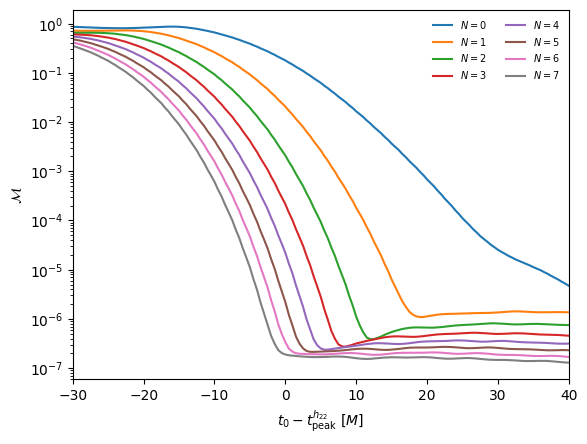

In [9]:
# Create figure
fig, ax = plt.subplots()

for modes in mode_list:
    
    # Create mismatch list
    mm_list = qnmfits.mismatch_t0_array(
        sim.times,
        sim.h[2,2],
        modes,
        Mf=sim.Mf,
        chif=sim.chif_mag,
        t0_array=t0_array,
    )
    
    # Add to figure
    ax.semilogy(t0_array, mm_list, label=f'$N = {modes[-1][-2]}$')
    
# Plot limits and labels
ax.set_xlim(t0_array[0], t0_array[-1])
ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax.set_ylabel('$\mathcal{M}$')

_ = ax.legend(ncol=2, frameon=False, fontsize=7)

Notice that at late times the mismatch does not rise - this is because the waveform now properly decays to zero.